In [1]:
import pybamm
import openpnm as op
import matplotlib.pyplot as plt
import os
from scipy import io
import numpy as np
from scipy.stats import lognorm as dist, kstest
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import openpnm as op
import ecm
%matplotlib inline

In [2]:
pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

In [4]:
save_parent = './pybamm_pnm_case2_Chen2020'
sub = '8A'
save_root = save_parent + '/' + sub
file_lower = os.path.join(save_root, 'var_Current_collector_current_density_lower')
file_upper = os.path.join(save_root, 'var_Current_collector_current_density_upper')
data_lower = io.loadmat(file_lower)['data']
data_upper = io.loadmat(file_upper)['data']
cwd = os.getcwd()
input_dir = os.path.join(cwd, 'input')
wrk.load_project(os.path.join(input_dir, 'MJ141-mid-top_m_cc_new.pnm'))
sim_name = list(wrk.keys())[-1]
project = wrk[sim_name]
net = project.network
Nspm = net.num_throats('spm_resistor')
data_amalg = np.hstack((data_lower, data_upper))
data_amalg = data_amalg[:-1, :]
weights = net['throat.arc_length'][net.throats('spm_resistor')]
int_weights = np.around(weights/weights.min()*100, 0).astype(int)


FileNotFoundError: [Errno 2] No such file or directory: './pybamm_pnm_case2_Chen2020/8A/var_Current_collector_current_density_lower.mat'

In [95]:
if np.any(np.isnan(data_amalg[-1, :])):
    data_amalg = data_amalg[:-1, :]
abs_min = data_amalg.min()
abs_max = data_amalg.max()

In [96]:
def plot(t):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_t = data_amalg[t, :]
    full_data_t = np.repeat(data_t, int_weights)
    sample = np.random.choice(full_data_t, 5000)
    args = dist.fit(sample)
    ks = kstest(sample, 'lognorm', args=args)
    start = data_t.min()
    end = data_t.max()
    x = np.linspace(start, end, 1000)
    ax.hist(data_t, bins=50, density=True, weights=weights)
    ax.plot(x, dist.pdf(x, *args))
    #ax.set_xlim(abs_min, abs_max)
    plt.show()

In [97]:
interact(plot, t=widgets.IntSlider(min=0, max=data_amalg.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=211), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(t)>

In [98]:
neg_inner_weights = net['throat.arc_length'][net.throats('spm_neg_inner')]
neg_inner_distance = np.cumsum(neg_inner_weights)
pos_inner_weights = net['throat.arc_length'][net.throats('spm_pos_inner')]
pos_inner_distance = np.cumsum(pos_inner_weights)
mean_t = []
m_minus_t = []
m_plus_t = []
Iy_t = []
for t in range(data_amalg.shape[0]):
    data_t = data_amalg[t, :]
    mean, _ = ecm.weighted_avg_and_std(data_t, weights)
    diff = (data_t - mean)*weights
    Iy = np.sum(weights*((data_t-mean)**3)/3)
    m_p = np.mean(diff[diff > 0])/np.mean(weights[diff > 0])
    m_m = np.mean(diff[diff <=0])/np.mean(weights[diff <=0])
    mean_t.append(mean)
    m_minus_t.append(m_m)
    m_plus_t.append(m_p)
    Iy_t.append(Iy)
min_t = np.min(data_amalg, axis=1)
max_t = np.max(data_amalg, axis=1)

In [99]:
def plot_lower(t):
    #data_t = data_amalg[t, :]
    #mean, _ = ecm.weighted_avg_and_std(data_t, weights)
    #m2 = np.sum(weights*(data_t - mean)**2)/np.sum(weights)
    #diff = (data_t - mean)*weights
    #m_plus = np.mean(diff[diff > 0])/np.mean(weights[diff > 0])
    #m_minus = np.mean(diff[diff <=0])/np.mean(weights[diff <=0])
    #m_mean = np.mean(diff)/np.mean(weights)
    mean = mean_t[t]
    m_minus = m_minus_t[t]
    m_plus = m_plus_t[t]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(neg_inner_distance, data_lower[t, :])
    ax.plot(pos_inner_distance, data_upper[t, :])
    ax.plot([0, pos_inner_distance.max()], [mean, mean], 'r--')
    ax.plot([0, pos_inner_distance.max()], [mean+m_plus, mean+m_plus], 'y--')
    ax.plot([0, pos_inner_distance.max()], [mean+m_minus, mean+m_minus], 'g--')
    ax.plot([0, pos_inner_distance.max()], [max_t[t], max_t[t]], 'k--')
    ax.plot([0, pos_inner_distance.max()], [min_t[t], min_t[t]], 'k--')
    ax.set_ylim(abs_min, abs_max)
    #plt.title(str(m_minus) +' '+str(m_plus)+' '+str(m_mean) +' '+str(np.sum(diff)))
    plt.show()

In [100]:
interact(plot_lower, t=widgets.IntSlider(min=0, max=data_amalg.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=211), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_lower(t)>

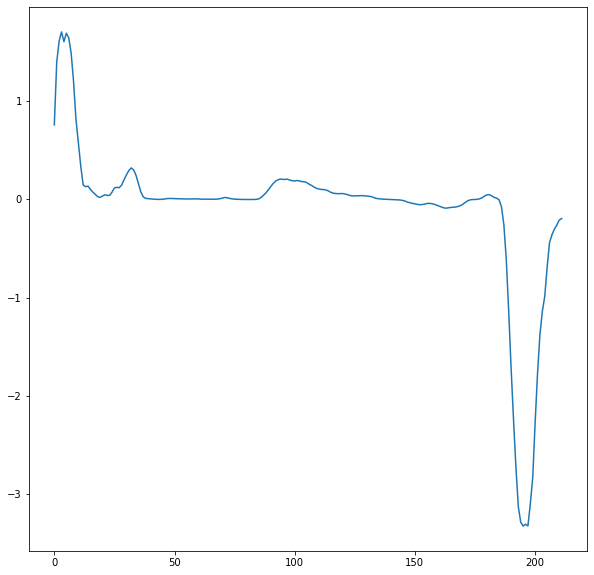

In [102]:
plt.figure(figsize=(10, 10))
plt.plot(Iy_t/mean)

In [91]:
mean

126.9831363697881